# Decision Tree Classification

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay

## Importing the data

In [2]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [3]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [4]:
df.head()

,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,situation,type_sol,surf_permeable,date_plantation,...,canisse_arbre,plaie_tronc,champignon_houppier,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,esperance_maintien,contrainte,classification_diagnostic
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,7,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLNC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,8,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,9,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLCF,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,1,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,2,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2


In [5]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')

df["label"]=df.classification_diagnostic
df= df.drop(["classification_diagnostic"], axis=1 )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quartier                 709 non-null    object 
 1   site                     709 non-null    object 
 2   cote_voirie              709 non-null    object 
 3   contrainte               709 non-null    object 
 4   genre_arbre              709 non-null    object 
 5   espece_arbre             709 non-null    object 
 6   situation                709 non-null    object 
 7   type_sol                 709 non-null    object 
 8   plaie_houppier           709 non-null    object 
 9   bois_mort_houppier       709 non-null    object 
 10  classe_age               709 non-null    object 
 11  ecorce_incluse_houppier  709 non-null    object 
 12  classe_hauteur           709 non-null    object 
 13  fissure_houppier         709 non-null    object 
 14  classe_circonference     7

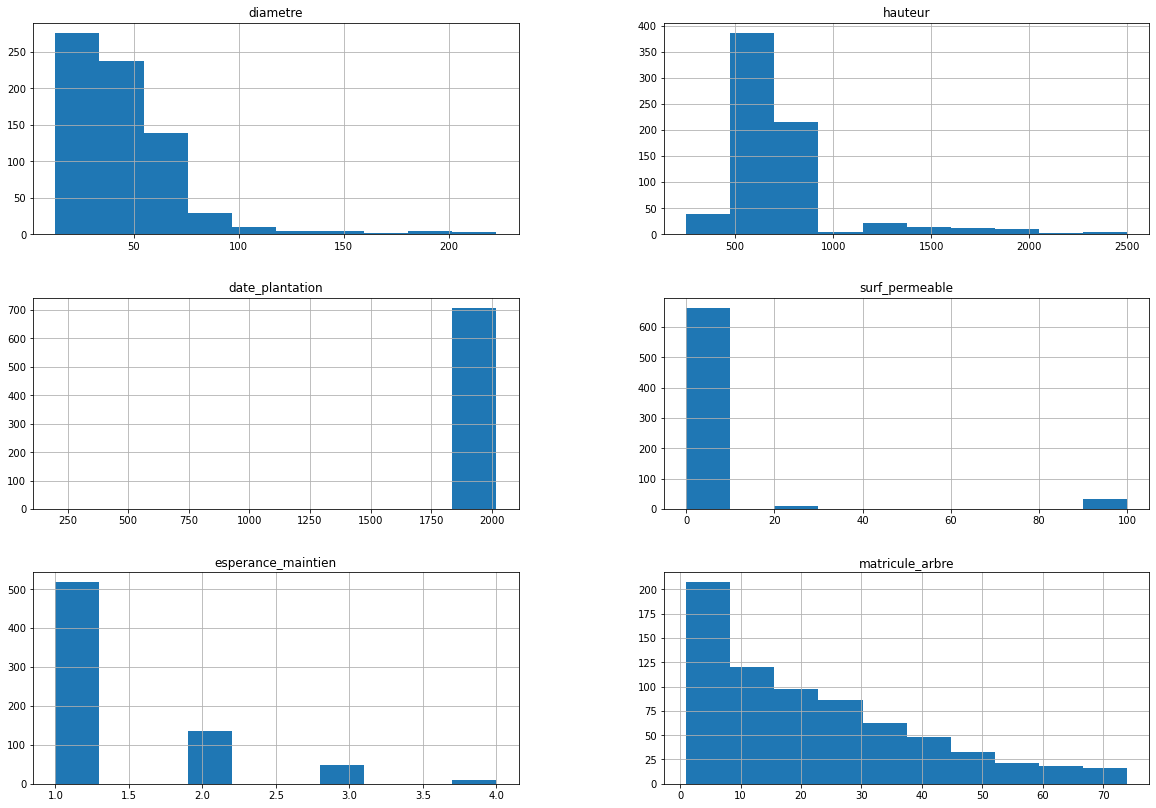

In [6]:
_ = df.hist(figsize=(20, 14))

In [7]:
cor_matrix = df.corr()
cor_matrix

,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
diametre,1.000000,0.759239,-0.155416,0.408231,0.329892,-0.109965
hauteur,0.759239,1.000000,-0.090306,0.604309,0.225723,-0.164903
date_plantation,-0.155416,-0.090306,1.000000,-0.071507,-0.033480,-0.007850
surf_permeable,0.408231,0.604309,-0.071507,1.000000,0.224826,-0.217633
esperance_maintien,0.329892,0.225723,-0.033480,0.224826,1.000000,-0.023423
matricule_arbre,-0.109965,-0.164903,-0.007850,-0.217633,-0.023423,1.000000


In [8]:
df.nunique()

quartier                    6
site                       30
cote_voirie                 2
contrainte                  2
genre_arbre                26
espece_arbre               37
situation                   4
type_sol                    9
plaie_houppier              5
bois_mort_houppier          3
classe_age                  4
ecorce_incluse_houppier     2
classe_hauteur              5
fissure_houppier            3
classe_circonference        7
port_arbre                  5
vigueur_pousse              4
champignon_collet           2
plaie_collet                7
champignon_tronc            2
fissure_tronc               3
rejet_tronc                 2
tuteurage_arbre             4
canisse_arbre               2
plaie_tronc                 6
champignon_houppier         2
diametre                   42
hauteur                    17
date_plantation            13
surf_permeable              9
esperance_maintien          4
matricule_arbre            74
label                       5
dtype: int

In [9]:
df['label'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: label, dtype: int64

In [10]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [11]:
print(X.shape)
print(y.shape)

(709, 32)
(709,)


In [12]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [13]:
X

array([[0.0, 1.0, 0.0, ..., 5.0, 1.0, 7],
       [0.0, 1.0, 0.0, ..., 5.0, 1.0, 8],
       [0.0, 1.0, 0.0, ..., 5.0, 1.0, 9],
       ...,
       [1.0, 0.0, 0.0, ..., 1.0, 1.0, 6],
       [1.0, 0.0, 0.0, ..., 1.0, 2.0, 7],
       [1.0, 0.0, 0.0, ..., 1.0, 1.0, 8]], dtype=object)

In [14]:
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 3, 1, 2, 1, 2, 3, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [16]:
print(X.shape)
print(y.shape)

(709, 190)
(709,)


In [17]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 237]
 [  1 408]
 [  2  43]
 [  3  11]
 [  4  10]]


In [18]:
type(X)

numpy.ndarray

In [19]:
type(y)

numpy.ndarray

## Splitting the dataset into the Training set and Test set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Feature Scaling

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 184:] = sc.fit_transform(X_train[:, 184:])
X_test[:, 184:]= sc.transform(X_test[:, 184:])

In [22]:
print(X_train)

[[0.0 0.0 1.0 ... -0.1396999422051156 1.005202295399419
  0.6331126721158673]
 [0.0 1.0 0.0 ... -0.09024014374723204 -0.5310502692676177
  -0.6220442687571982]
 [0.0 1.0 0.0 ... -0.1396999422051156 1.005202295399419
  -0.3938339158711863]
 ...
 [1.0 0.0 0.0 ... -0.2880793375787663 -0.5310502692676177
  -0.16562356298517442]
 [1.0 0.0 0.0 ... -0.2880793375787663 -0.5310502692676177
  -0.16562356298517442]
 [0.0 1.0 0.0 ... -0.2880793375787663 2.541454860066456
  -0.7361494452002042]]


In [23]:
print(X_test)

[[0.0 1.0 0.0 ... -0.1396999422051156 1.005202295399419
  2.3446903187609567]
 [0.0 1.0 0.0 ... -0.1396999422051156 1.005202295399419
  0.9183756132233821]
 [0.0 0.0 0.0 ... -0.2880793375787663 -0.5310502692676177
  -0.9073072098647131]
 ...
 [0.0 1.0 0.0 ... -0.1396999422051156 1.005202295399419
  2.0023747894319386]
 [0.0 1.0 0.0 ... -0.1396999422051156 1.005202295399419
  -1.078464974529222]
 [0.0 0.0 0.0 ... 4.608440709751707 -0.5310502692676177
  -1.135517562750725]]


## Logistic Regression

In [24]:
%%time
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, y_train)

Wall time: 132 ms


LogisticRegression(max_iter=1000, random_state=0)

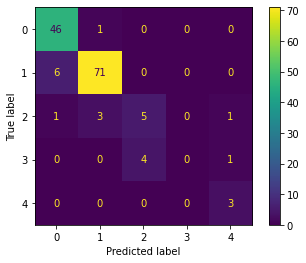

model accuracy: 0.880


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [26]:
%%time
from sklearn.model_selection import cross_val_score
classifier = LogisticRegression(random_state = 0, max_iter=1000)
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.89473684 0.85964912 0.84955752 0.89380531 0.88495575]
Accuracy: 87.65 %
Standard Deviation: 1.85 %
Wall time: 465 ms


## Decision Tree Model

## Training the Decision Tree Classification model on the Training set

In [27]:
%%time
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy',random_state = 0)
classifier.fit(X_train, y_train)

Wall time: 22.8 ms


DecisionTreeClassifier(criterion='entropy', random_state=0)

## Predicting the Test set results

In [28]:
classifier.tree_.node_count

163

In [29]:
classifier.tree_.max_depth

15

In [30]:
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

## Making the Confusion Matrix

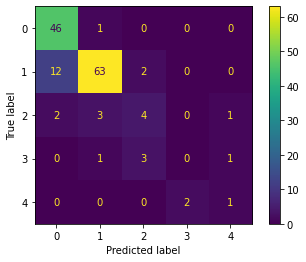

model accuracy: 0.803


In [31]:
cm = confusion_matrix(y_test, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [32]:
%%time
from sklearn.model_selection import cross_val_score
classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth=6, max_leaf_nodes=16,random_state = 0)
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.84210526 0.79824561 0.80530973 0.84070796 0.87610619]
Mean Accuracy: 83.25 %
Standard Deviation: 2.82 %
Wall time: 32.7 ms


## Random Forest Model

In [33]:
%%time
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

Wall time: 144 ms


RandomForestClassifier(criterion='entropy', random_state=0)

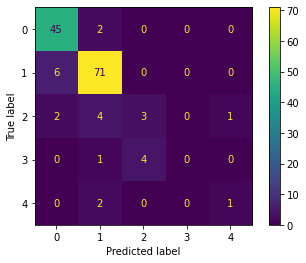

model accuracy: 0.845


In [34]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [35]:
%%time
from sklearn.model_selection import cross_val_score
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.85087719 0.84210526 0.87610619 0.86725664 0.87610619]
Accuracy: 86.25 %
Standard Deviation: 1.37 %
Wall time: 631 ms


## Bagging Model

In [36]:
%%time
from sklearn.ensemble import BaggingClassifier
classifier = BaggingClassifier(n_estimators = 10, random_state = 0)
classifier.fit(X_train, y_train)

Wall time: 68 ms


BaggingClassifier(random_state=0)

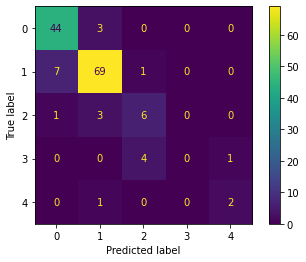

model accuracy: 0.852


In [37]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [38]:
%%time
from sklearn.model_selection import cross_val_score
classifier = BaggingClassifier(n_estimators = 100, random_state = 0)
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.85087719 0.85087719 0.87610619 0.87610619 0.88495575]
Accuracy: 86.78 %
Standard Deviation: 1.42 %
Wall time: 2.87 s


## Adaptive Boosting

In [39]:
%%time
from sklearn.ensemble import AdaBoostClassifier
base_estimator= DecisionTreeClassifier(criterion = 'entropy',max_depth= 4, max_leaf_nodes= 11, random_state = 0)
adaclassifier = AdaBoostClassifier(base_estimator= base_estimator, n_estimators=200, learning_rate=0.4, algorithm='SAMME', random_state= 0)
adaclassifier.fit(X_train, y_train)

Wall time: 1.18 s


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=4,
                                                         max_leaf_nodes=11,
                                                         random_state=0),
                   learning_rate=0.4, n_estimators=200, random_state=0)

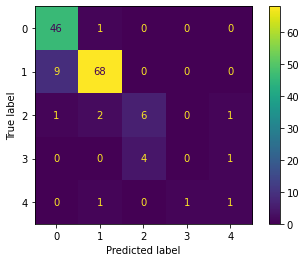

model accuracy: 0.852


In [40]:
y_pred = adaclassifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [41]:
%%time
from sklearn.model_selection import cross_val_score
classifier = AdaBoostClassifier(n_estimators=350, learning_rate=0.4, algorithm='SAMME', random_state= 0)
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.70175439 0.71929825 0.71681416 0.71681416 0.67256637]
Accuracy: 70.54 %
Standard Deviation: 1.76 %
Wall time: 6.97 s


## Gradient Boosting

In [42]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier(n_estimators=350, learning_rate=0.01, max_depth=6, max_leaf_nodes=16, subsample= 0.7, random_state= 0)
classifier.fit(X_train, y_train)

Wall time: 4.22 s


GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_leaf_nodes=16,
                           n_estimators=350, random_state=0, subsample=0.7)

In [43]:
print(classifier.feature_importances_)

[6.20068183e-03 9.59797114e-03 1.12349131e-02 2.53563424e-03
 9.73762394e-04 4.52480711e-04 3.12836333e-03 1.37623182e-04
 5.03096561e-03 6.32951934e-04 3.51189046e-04 1.08234287e-03
 1.02398736e-03 0.00000000e+00 4.15466233e-03 2.87623525e-05
 8.31678463e-05 2.16580658e-03 1.78864304e-03 3.82241181e-03
 3.25945442e-03 1.22443279e-03 9.75007278e-04 3.22874963e-03
 9.35147896e-04 1.59434699e-03 1.64869183e-03 2.85989590e-05
 9.02427321e-09 1.02404504e-04 2.35495580e-05 0.00000000e+00
 1.83284217e-03 0.00000000e+00 3.26722654e-03 1.71761894e-03
 1.48350507e-02 1.13044577e-02 3.30039670e-03 2.54134992e-03
 2.57426663e-03 2.00067683e-03 1.12349653e-04 1.23920840e-03
 3.11494686e-04 6.28769544e-03 0.00000000e+00 1.09056047e-03
 9.16876374e-04 3.01786205e-03 1.37541185e-10 2.76267299e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.99774881e-04
 1.14964123e-03 3.16734125e-03 0.00000000e+00 1.94995090e-03
 7.35377249e-04 0.00000000e+00 2.26640409e-03 0.00000000e+00
 1.11230075e-03 0.000000

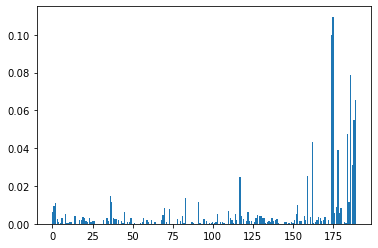

In [44]:
# plot
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

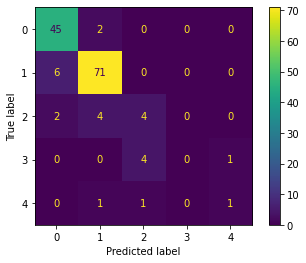

model accuracy: 0.852


In [45]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Applying K-Fold Cross Validation to Gradient Boosting

In [46]:
%%time
from sklearn.model_selection import cross_val_score
classifier = GradientBoostingClassifier(n_estimators=350, learning_rate=0.01, subsample=0.7, random_state= 0)
accuracies = cross_val_score(estimator = classifier, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.86842105 0.81578947 0.86725664 0.89380531 0.88495575]
Accuracy: 86.60 %
Standard Deviation: 2.71 %
Wall time: 10.2 s


DT: 0.837743 (0.023793)
DTWP: 0.851852 (0.004320)
RF: 0.843034 (0.019954)
BGG: 0.873016 (0.008640)
AB: 0.862434 (0.011430)
GB: 0.880071 (0.009977)


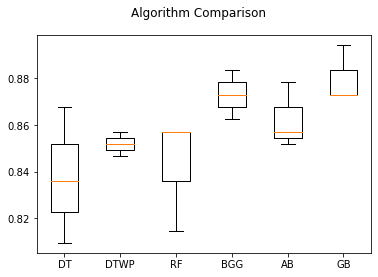

In [59]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
# load dataset
# prepare configuration for cross validation test harness
# prepare models
models = []
#models.append(('LR',LogisticRegression(random_state = 0, max_iter=1000)))
models.append(('DT',DecisionTreeClassifier(criterion = 'entropy',random_state = 0)))
models.append(('DTWP',DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=8, max_leaf_nodes= 50, ccp_alpha=0.00625)))
models.append(('RF',RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)))
models.append(('BGG',BaggingClassifier(n_estimators = 100, random_state = 0)))
models.append(('AB',adaclassifier)) 
models.append(('GB',GradientBoostingClassifier(n_estimators=350, learning_rate=0.01, max_depth=6, max_leaf_nodes=16, subsample= 0.7, random_state= 0)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()